# ASL Handshape Data

## Description of data
Link to data found on Nicolas Pugeault's website
(http://empslocal.ex.ac.uk/people/staff/np331/index.php?section=FingerSpellingDataset). The dataset is of 24 static handshapes corresponding to English letters (excluding the letters "J" and "Z" since they require motion). The data comprises of 5 different non-native signers of about 60,000 RGB (intensity) images and depth images. The images have some rotational variance as the subject moved their hand during the image capture.

## Notebook setup

Run this section if data is already partially processed 

In [1]:
import os
import re
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image 
from functools import reduce

## Variables needed for reference throughout sections
dataset_url = 'www.cvssp.org/FingerSpellingKinect2011/fingerspelling5.tar.bz2'
filename = 'fingerspelling5.tar.bz2'
# Data directory
final_data_dir = 'dataset'
# Data's top-level directory (after download & decompreshion)
dataset_dir = 'dataset5'
# Filename for image sizes
img_sizes_csv = 'image_sizes.csv' 

## Grabbing data

Below is a script to download the data to the local machine. Note that compressed file is over 2GB. If the data was already retrieved, you can skip this section and start with the preprocessing the dataset.

In [ ]:
# Link to dataset and 
os.system('wget {URL}'.format(URL=dataset_url))

In [ ]:
# Uncompress
os.system('tar xjf {}'.format(filename))

## Removing and relabelling data

Only RGB image data is needed and should be relabelled so that the files can be easily be placed into one directory but still contain metadata for classification, validation, and testing.

In [ ]:
# Make a new data directory if doesn't exist
if not os.path.exists(final_data_dir):
    os.makedirs(final_data_dir)

# Define patterns for depth files & RGB files 
# Format: `depth_0_0528.png` & `color_12_0137.png`
pattern_depth_file = '(depth\w*.png)'
pattern_rgb_file = 'color_\d*_(\d*).png'
# Number of files renamed/delted
n_del, n_rename = 0,0

# Save that this is a new subject (numerical since letter can be confusing)
# Each subject in directory with a letter ('A','B','C',...)
for (subject_id, subject_dir) in enumerate(os.listdir(dataset_dir)):
    # Directories for each letter (excluding "j" & "z")
    path_to_subject = os.path.join(dataset_dir, subject_dir)
    
    for letter_dir in os.listdir(path_to_subject):
        # Use letter as number ('a' starts @ 00)
        letter_id = ord(letter_dir.lower()) - ord(('a'))
        letter_id = f'0{letter_id}' if letter_id < 10 else letter_id
        path_to_letter = os.path.join(path_to_subject, letter_dir)
        
        for image_file in os.listdir(path_to_letter):
            # Remove depth file
            if re.search(pattern_depth_file, image_file):
                path_depth_file = os.path.join(path_to_letter, image_file)
                os.remove(path_depth_file)
                # Inform depth file removed
                print(f'\r#{n_del}: Depth file deleted {path_depth_file}', end='')
                n_del += 1
            else:
                # Get ID of each file (None if not matched)
                num_id = re.match(pattern_rgb_file, image_file)
                if num_id:
                    # Get the matching parathesis only
                    num_id = num_id.group(1)
                    path_image_file = os.path.join(path_to_letter, image_file)
                    # Rename image
                    new_image_name = f'{letter_id}_{subject_id}_{num_id}.png'
                    new_path_image_file = os.path.join(final_data_dir, new_image_name)
                    os.rename(path_image_file, new_path_image_file)
                    # Inform image renamed
                    print(f'\r#{n_rename}: {new_path_image_file} renamed from {path_image_file}', end='')
                    n_rename += 1
            sys.stdout.flush()

## Change images to grayscale

RGB images will be turned into grayscale since color shouldn't be necessary for recognition. This also should reduce the file sizes of the images and can help generalize to future datasets.

In [ ]:
# Convert image to grayscale and save file
def img_to_gray(img_file):
    img_path = os.path.join(final_data_dir, img_file)
    img = Image.open(img_path, 'r').convert('L')
    img.save(img_path)
    
# Keep track of image number
n = 1 
file_list = [x for x in os.listdir(final_data_dir) if re.search('\w*png', x)]
n_imgs = len(file_list)
errors_convert = []

# Iterate over each image
for img_filename in file_list:
    print(f'\r#{n: <5} of {n_imgs}: Converting image `{img_filename}` to gray', end='')
    # Keep track of files that were not successfully converted
    try:
        img_to_gray(img_filename)
    except:
        errors_convert.append((n,img_filename))
        print(f'`{img_filename}` was NOT converted')
    n += 1
    sys.stdout.flush()

## Exploring image size

The next step would be to make all images the same size, however it is unclear what are the images' current sizes. So a quick exploration will done to determine how the images will be resized (and padded if needed).

In [ ]:
# Create headers for dataframe columns
img_dict = {'filename':[], 'width':[], 'height':[]}

# Get only relevant files
file_list = [x for x in os.listdir(final_data_dir) if re.search('\w*png', x)]
for img_filename in file_list:
    # Open up the image file and get relevant info
    img_path = os.path.join(final_data_dir, img_filename)
    img = Image.open(img_path)
    width, height = img.size
    # Add it to a dictionary before converting to dataframe
    img_dict['filename'].append(img_filename)
    img_dict['width'].append(width)
    img_dict['height'].append(height)
    
# Convert to dataframe and save to CSV    
img_df = pd.DataFrame(data=img_dict)
img_df.to_csv(img_sizes_csv)

In [2]:
# Load in CSV to df if continuing
img_df = pd.read_csv(img_sizes_csv)

In [3]:
# Creating some new variables to get better idea of images
img_df['area'] = img_df.apply(lambda row: row.width * row.height, axis=1)
img_df['aspect'] = img_df.apply(lambda row: row.width / row.height, axis=1)

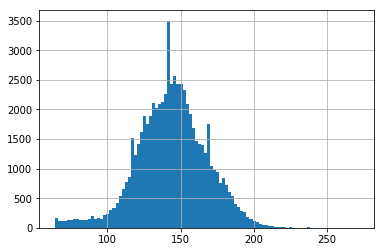

In [4]:
img_df['height'].hist(bins=100)

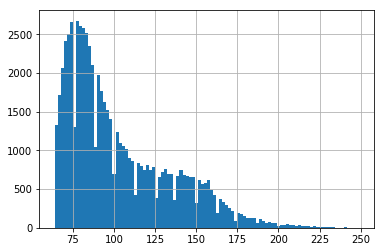

In [5]:
img_df['width'].hist(bins=100)

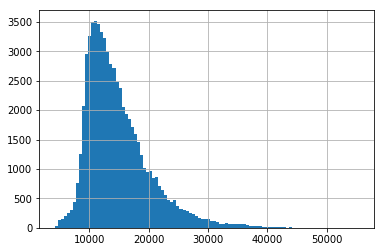

In [6]:
# Observing the total pixel area
img_df['area'].hist(bins=100)

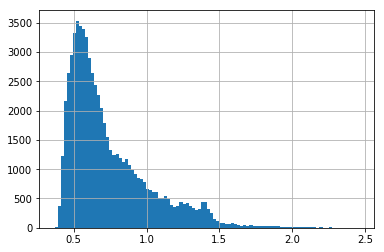

In [7]:
# Observing the total pixel area
img_df['aspect'].hist(bins=100)

In [8]:
img_df.describe()

,Unnamed: 0,height,width,area,aspect
count,65774.00000,65774.000000,65774.00000,65774.000000,65774.000000
mean,32886.50000,143.769103,103.16952,14847.704260,0.741979
std,18987.46264,23.951306,31.83872,5443.550522,0.282801
min,0.00000,64.000000,64.00000,4160.000000,0.368421
25%,16443.25000,129.000000,78.00000,11005.750000,0.537313
50%,32886.50000,144.000000,93.00000,13580.000000,0.649007
75%,49329.75000,159.000000,123.00000,17375.000000,0.872549
max,65773.00000,272.000000,249.00000,55458.000000,2.460526


### Image sizes observations

Looking at our images different sizes, one can pick up on some patterns in the data. First the smallest the height or width each goes down is $64$ pixels while the maximums go to over about $270$ and $250$ pixels for height and width respectively. Height is roughly a normal curve centered near $145$ pixels while width is skewed towards smaller values with an average of about $100$ pixels.

Aspect ratio and area metrics were also created from the data. The area gives us literally how many inputs there would be for the model if we simply input the pixels. The aspect ratio gives the relative size of height and width.

One can notice that the aspect ratio trends below $1.0$ meaning that most images are taller than they are wide. This makes sense since the images likely capture part of the arm which for most signs creates a more vertical image. Less than $25\%$ of all images have an aspect ratio above the $1.0$ which corresponds with images wider than they are tall.

One can also notice that the area metric is heavily skewed toward smaller values. This fits with the aspect ratio and likely is because of the skew in width. The average number of pixels in the images is about $15000$ pixels and less than $25\%$ have more than $18000$ pixels.

### Determinig image resizing action

Taking this information from the dataset, a procedure can be created to resize these images. Since the model will be using a convolutional neural network (CNN) architecture, the images must be fixed and benefits in being square that is the width and height must be equal. Ideally, one would like the images to keep as much information as possible during the resize but due to computing resource limits, the images shouldn't simply enlarged to fit to the maximums. Therefore, in resizing the images most images should retain most (if not all) of their information while there are fewer images losing information. Note that the images should not be cropped since they have already been cropped around the images' handshapes.

From the data exploration, it can be observed that most images are taller than wide. It would then make sense that resizing the data should favor taller images since this is more common in the data. One solution is to add padding to images so that the width matches with the height. However, by adding the padding can give bias to the model if particular letters have differing aspect ratios (see the histogram plots below). In other words, the model could simply learn based on the padding instead of the handshape in the image. Thus stretching/squeezing the image seems to be preferred even if the images will lose more information. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x72b34698e400>,
      dtype=object)

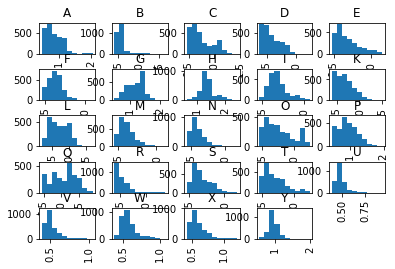

In [9]:
# Get the handshape from file name (convert number to letter)
img_df['handshape'] = img_df.apply(lambda row: chr(int(row.filename[:2])+65), axis=1)
# Plot the histograms by handshape
img_df['aspect'].hist(by=img_df['handshape'])


* Width cuttoff @ 125 (75% are less than that)
  - 125^2 -> 15625
  - But height cutoff: >75% have more pixels 
* Height cutoff @ 160 (75% are less than tha)
  - 160^2 --> 25600
  - Width: >>75% have that
* Area represents the data --> Keep as much as possible
  - Over 75% have less than 18000 total pixels [134,135,136] --> [17956,18225,18496]